# <center> Deep Learning Project</center>
## <center>Spooky Authors Identification</center>
### <center>Bidirectional LSTM</center>
#### <center>Score on Kaggle: 0.76 log loss</center>


---


*   Eduardo Brendao (MLDM)
*   Mohammad Poul Doust (MLDM)



In [0]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
import pandas as pd
import numpy as np

from keras.models import Sequential
#from keras.layers.recurrent import LSTM, CuDNNLSTM
from keras.layers import Bidirectional, CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, SpatialDropout1D
from keras.optimizers import SGD,Adam
from keras.layers.core import Dense,Activation,Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence,text
from keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# We get the text from Kaggle -- feel free to use my API key :)
import os
os.environ['KAGGLE_USERNAME'] = "extremelydifficult" # username from the json file
os.environ['KAGGLE_KEY'] = "238120927f9705524c124fcbdb19b699" # key from the json file
!kaggle competitions download -c spooky-author-identification
!unzip \*.zip

  0% 0.00/1.26M [00:00<?, ?B/s]
100% 1.26M/1.26M [00:00<00:00, 84.5MB/s]
  0% 0.00/538k [00:00<?, ?B/s]
100% 538k/538k [00:00<00:00, 74.6MB/s]
  0% 0.00/29.4k [00:00<?, ?B/s]
100% 29.4k/29.4k [00:00<00:00, 30.3MB/s]
Archive:  train.zip
  inflating: train.csv               

Archive:  test.zip
  inflating: test.csv                

Archive:  sample_submission.zip
  inflating: sample_submission.csv   

3 archives were successfully processed.


In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

In [0]:
#convert the authors/labels into one hot encoded values
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(train_df.author.values)
y = np_utils.to_categorical(y)

In [0]:
#divide the data into train and validation 
x_train, x_valid, y_train, y_valid = train_test_split(train_df.text.values,
                                                      y,
                                                      stratify = y,                                        
                                                     test_size = 0.1)

In [0]:
#use Keras Tokenizer to tokenize the texts
token = text.Tokenizer(num_words = None)
max_len = 80

token.fit_on_texts(list(x_train) + list(x_valid))
xtrain_seq = token.texts_to_sequences(x_train)
xvalid_seq = token.texts_to_sequences(x_valid)

print(xtrain_seq[:1])
# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len,padding = 'post')
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len,padding = 'post')
print(xtrain_pad[:1])

[[6, 93, 203, 3, 5, 5390, 3103, 4, 7451, 22, 4, 10, 445, 807, 10, 249, 2, 308, 8, 1943, 3, 1, 8537, 3, 7452, 2, 32, 186, 778, 170, 1073, 2545, 4, 22]]
[[   6   93  203    3    5 5390 3103    4 7451   22    4   10  445  807
    10  249    2  308    8 1943    3    1 8537    3 7452    2   32  186
   778  170 1073 2545    4   22    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]


In [0]:
word_index = token.word_index
def get_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                         300,
                         input_length=max_len))
    model.add(SpatialDropout1D(0.3))
    # model.add(Bidirectional(CuDNNLSTM(300, dropout=0.3, recurrent_dropout=0.3,return_sequences = True)))
    # model.add(Bidirectional(CuDNNLSTM(300, dropout=0.3, recurrent_dropout=0.3)))
    model.add(Bidirectional(CuDNNLSTM(300,return_sequences = True)))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(CuDNNLSTM(300)))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(3))
    model.add(Activation('softmax'))
    adam = Adam(lr=0.01, decay = 0.05)
    model.compile(loss='categorical_crossentropy', optimizer=adam,
                 metrics=['accuracy'])
    return model

In [0]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

history = LossHistory()

In [0]:
def plot_loss():
    #plot training curve
    loss = history.losses
    val_loss = history.val_losses
    acc = history.acc
    val_acc = history.val_acc

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Acc - Loss Trend')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.plot(acc, 'black', label='Training Accuracy')
    plt.plot(val_acc, 'red', label='Validation Accuracy')
    plt.xticks(range(0,10)[0::2])
    plt.legend()
    plt.show()
    

In [0]:
earlystop = EarlyStopping(monitor='val_loss', patience=6, verbose=0, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', epsilon=0.0001, min_lr=0.0000001)

model = get_model()
model.fit(xtrain_pad, y=y_train, batch_size=16, epochs=70, verbose=1, 
          validation_data=(xvalid_pad, y_valid), callbacks=[earlystop,history,reduceLR])

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 17621 samples, validate on 1958 samples
Epoch 1/70
17621/17621 [==============================] - 40s 2ms/step - loss: 1.0956 - accuracy: 0.4122 - val_loss: 1.0650 - val_accuracy: 0.4459
Epoch 2/70
17621/17621 [==============================] - 39s 2ms/step - loss: 1.0248 - accuracy: 0.4865 - val_loss: 1.0170 - val_accuracy: 0.4780
Epoch 3/70
17621/17621 [==============================] - 40s 2ms/step - loss: 0.9272 - accuracy: 0.5441 - val_loss: 0.9295 - val_accuracy: 0.5378
Epoch 4/70
17621/17621 [==============================] - 40s 2ms/step - loss: 0.7891 - accuracy: 0.6148 - val_loss: 0.8295 - val_accuracy: 0.5996
Epoch 5/70
17621/17621 [==============================] - 40s 2ms/step - loss: 0.7225 - accuracy: 0.6370 - val_loss: 0.7751 - val_accuracy: 0.6113
Epoch 6/70
17621/17621 [==============================] - 40s 2ms/step - loss: 0.6825 - accuracy: 0.6523 - val_loss: 0.7781 - val_accuracy: 0.6124
Epoch 7/70
17621/17621 [==============================] - 40s 2ms/ste

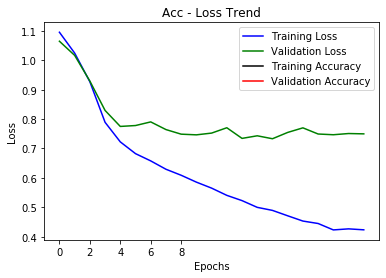

In [0]:
plot_loss()

In [0]:
#the same operations are also carried out on the test set
xtest_seq = token.texts_to_sequences(test_df.text)
xtest_pad = sequence.pad_sequences(xtest_seq,maxlen = max_len,padding = 'post')

In [0]:
# Now predict
prediction = model.predict(xtest_pad)

In [0]:
a2c = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
result = pd.read_csv('sample_submission.csv')
for a, i in a2c.items():
    result[a] = prediction[:, i]
    
result.to_csv('lstmsubmission_bidirectional.csv',index = False)
result.head()

,id,EAP,HPL,MWS
0,id02310,0.031861,0.036980,0.931159
1,id24541,0.931505,0.068312,0.000182
2,id00134,0.548777,0.442294,0.008930
3,id27757,0.889694,0.109807,0.000498
4,id04081,0.860524,0.138589,0.000887


In [0]:
result.head(10)

,id,EAP,HPL,MWS
0,id02310,0.010559,0.023715,0.965726
1,id24541,0.999765,0.000082,0.000153
2,id00134,0.000003,0.999988,0.000009
3,id27757,0.978980,0.006776,0.014244
4,id04081,0.998589,0.000321,0.001089
5,id27337,0.999989,0.000003,0.000007
6,id24265,0.967493,0.015826,0.016681
7,id25917,0.004774,0.005418,0.989808
8,id04951,0.999993,0.000003,0.000004
9,id14549,0.937388,0.020674,0.041938
